# Frequency-Domain FLIM Simulator (FD-FLIM)

### Overview
This notebook reproduces the simulation of **Figure 5** of the research article:
**"Addressing the spatio-temporal blurring effect on Fluorescence Lifetime Imaging Microscopy"**.

It simulates Frequency-Domain Fluorescence Lifetime Imaging Microscopy (FD-FLIM) measurements under controlled conditions to demonstrate how optical diffraction (blurring) mixes lifetime signals at the boundaries of fluorophores.

## Physical Model

The simulation assumes a single-exponential fluorescence decay:

$$I(t) = I_0 e^{-t/\tau}$$

Under sinusoidal excitation with angular frequency $\omega$, the fluorescence signal is **phase-shifted** ($\phi$) and **demodulated** ($M$). The fundamental relationships used in this notebook are:

### Phase Lifetime
$$\tan(\phi) = \omega \tau $$

### Modulation Lifetime
$$M = \frac{1}{\sqrt{1 + (\omega \tau)^2}}$$

These relations form the basis of FD-FLIM lifetime estimation.

## Workflow
1. Temporal Simulation: Generate ideal 1D signals for specific lifetimes.
2. Spatial Construction: Place fluorophores in a 3D $(x, y, t)$ grid.
3. Optical Blurring: Convolve the grid with a Gaussian Point Spread Function (PSF).
4. Phasor Analysis: Convert the blurred signals to phasor coordinates to
visualize the "spatio-temporal mixing."

In [6]:
# Check Python version — the notebook was run using Python 3.12.11
from platform import python_version
print(f"Python version: {python_version()}")

Python version: 3.12.12


In [5]:
# Install necessary Python libraries for the notebook
# Required Libraries (Uncomment if needed)
!pip install phasorpy # For phasor analysis
!pip install cmcrameri # For perceptual colormaps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 6.4 MB/s eta 0:00:00


## 1. Setup and Helper Functions
Defining plotting standards and utility functions for signal verification.

In [7]:
def format_plot(ax):
    """
    Standardizes plot aesthetics for publication-quality figures.
    """
    # Font sizes
    title_size = 16
    axtitles = 14
    ticksize = 12
    ax.title.set_fontsize(title_size)
    ax.xaxis.label.set_fontsize(axtitles)
    ax.yaxis.label.set_fontsize(axtitles)
    ax.tick_params(axis='both', labelsize=ticksize)

In [8]:
# Import standard libraries
import numpy as np # For numerical operations
from matplotlib import pyplot # For plotting
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc # For perceptual colormaps

# Import phasor analysis functions from phasorpy phasorpy is the core engine for
# transforming time-domain signals into phasor coordinates (G, S)
from phasorpy.phasor import (
    phasor_from_signal,
)
from phasorpy.lifetime import phasor_from_lifetime, lifetime_to_signal, phasor_calibrate

In [9]:
# This function is used to assert that calibrated phasor coordinates match the expected theoretical results.
# It leverages `numpy.testing.assert_allclose` for numerical comparison.
def verify_signal(
    signal,
    reference_signal,
    frequency,
    reference_lifetime,
    lifetimes,
    fractions,
):
    """Verify calibrated phasor coordinates match expected theoretical values."""
    # Calculate phasor coordinates from the generated signal and calibrate them
    calibrated_phasor = phasor_calibrate(
        *phasor_from_signal(signal)[1:],
        *phasor_from_signal(reference_signal),
        frequency,
        reference_lifetime,
    )

    # Calculate the theoretical position based on the input lifetimes
    theoretical_phasor = phasor_from_lifetime(
        frequency, lifetimes, fractions
    )

    # Assert that simulated and theoretical values are equal
    # throw AssertionError if they do not match
    np.testing.assert_allclose(calibrated_phasor, theoretical_phasor)

## 2. Simulation Parameters

Here we define the Temporal Physics (frequency, lifetimes) and the Spatial Optics (pixel size, PSF).

* Frequency: 80 MHz (standard for many FLIM systems).
* Lifetimes: We simulate two distinct species ($\tau_2=1.0$ ns and $\tau_4=4.0$ ns).
* Optics: `sigma_nm` defines the extent of the diffraction blur (Point Spread Function).
* Geometry:
 `cx_1` and `cx_2` define the distance between the two fluorophores to simulate overlapping signals.

In [10]:
# Define the parameters used throughout the notebook:

## Temporal parameters

frequency = 80.0  # fundamental frequency in MHz
period = (1 / frequency) * 1e3 # period of fundamental frequency in ns
reference_lifetime = 0.3  # reference signal lifetime in ns (used for calibration)

# Lifetime of signals
tau_1 = 0.5
tau_2 = 1.0
tau_3 = 2.0
tau_4 = 4.0

lifetimes = [tau_2, tau_4]  # lifetime in ns
fractions = [0.5, 0.5]  # fractional intensities

settings = {
    'samples': 256,  # number of samples to synthesize (time bins per period)
    'mean': 10.0,  # average intensity
    'background': 0.0,  # no signal from background
    'zero_phase': 0.0,  # location of IRF peak in the phase
    'zero_stdev': None,  # standard deviation of IRF in radians
}

## Spatial parameters

pxsz = 5                         # Pixel size in nm
# Optics (Diffraction limit)
sigma_nm = 100                   # PSF sigma in nm. Equivalent to a FWHM of ~235 nm
sigma_px = int(sigma_nm / pxsz)  # PSF sigma converted to pixels

# Dimensions of the image
x_dim = 127
y_dim = 127              # Image size in pixels
center = np.ceil(x_dim/2).astype(int)

cy = center                      # y-coordinate reference of center for image matrix

## Define the separation distance of the fluorophores

# Option 1: Both fluorophores in the center (Uncomment if needed)
#cx_1 = center
#cx_2 = center

# Option 2: Sparrow's resolution limit  (Uncomment if needed)
#cx_1 = center - sigma_px #Left Fluorophore
#cx_2 = center + sigma_px #Right Fluorophore

# Option 3: Rayleigh Criterion (Uncomment if needed)
#cx_1 = int(center - 1.25 * sigma_px)
#cx_2 = int(center + 1.25 * sigma_px)


# Option 4: No diffraction-limited (Distinctly separated)
cx_1 = int(center - 2 * sigma_px)
cx_2 = int(center + 2 * sigma_px)


# Setup visualization parameters
color = 'PRGn' #'cmc.batlowK'
legendtitles = '10'

## 3. Temporal Signal Synthesis

Before creating images, we simulate the raw signals for a multi-exponential decay to verify that the math (Signal -> Phasor) works correctly using the `verify_signal` function defined earlier (Section 1).

In [11]:
# Synthesize a multi-exponential fluorescence signal and a reference signal based on the defined temporal parameters
signal_multi, instrument_response, times = lifetime_to_signal(
    frequency, lifetimes, fractions, harmonic=1, **settings
)

reference_signal, _, _ = lifetime_to_signal(
    frequency, reference_lifetime, harmonic=1, **settings
)
# Verify the calibrated phasor coordinates of the multi-exponential signal against theoretical values
verify_signal(signal_multi, reference_signal, frequency, reference_lifetime, lifetimes,  fractions)

### Visualizing the Phase Shift
The plot below shows the time-domain signals converted to Phase Angles. Note how the *Multi-exponential* signal is shifted relative to the *Instrument Response* and the *Reference*. This shift encodes the lifetime information.

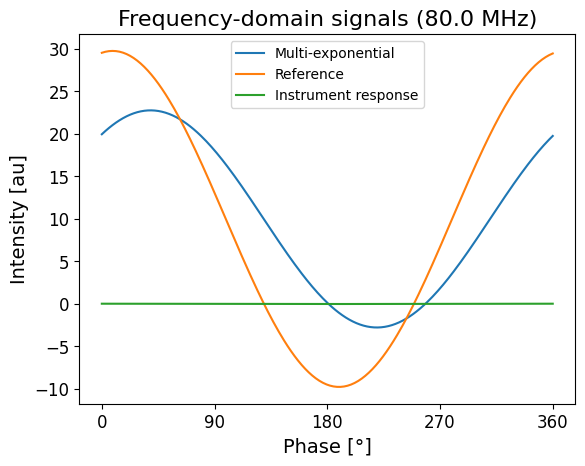

In [12]:
# Conversion from time points to phase angles
c_f = 1e-3                  # Conversion factor

T = 1 / (frequency * c_f)   # Frequency to Period in ns
phase = (times / T) * 360   # Time to phase angle in degrees

# Plot the synthesized multi-exponential signal, the reference signal, and the instrument response
fig, ax = pyplot.subplots()
ax.set(
    title=f'Frequency-domain signals ({frequency} MHz)',
    xlabel='Phase [°]',
    ylabel='Intensity [au]',
    xticks=[0, 90, 180, 270, 360],
)
format_plot(ax)
ax.plot(phase, signal_multi, label='Multi-exponential')
ax.plot(phase, reference_signal, label='Reference')
ax.plot(phase, instrument_response, label='Instrument response')
ax.ticklabel_format(axis='y')
ax.legend(fontsize=legendtitles)
pyplot.show()

## 4. Single-Exponential Components
Here we simulate the pure signals for the two specific lifetimes we will use in the image: $\tau_2$ and $\tau_4$.

In [13]:
# Synthesize single-exponential fluorescence signals for individual fluorophores (`tau_2` and `tau_4`) based on the defined parameters
signal_mono, _, _ = lifetime_to_signal(frequency, lifetimes, harmonic=1, **settings)
signal_1 = signal_mono[1] # Fluorophore with tau_4 (Longer lifetime)
signal_2 = signal_mono[0] # Fluorophore with tau_2 (Shorter lifetime)

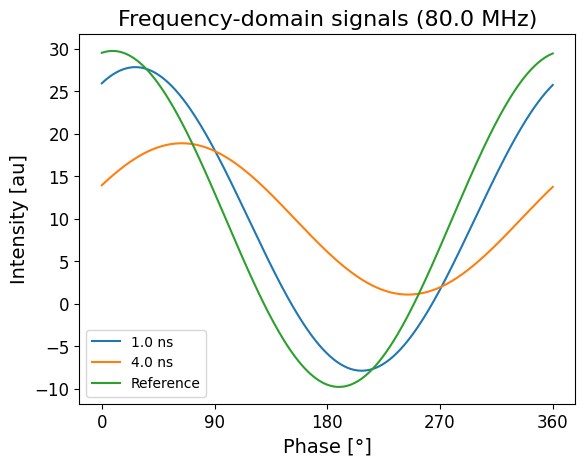

In [14]:
# Plot the individual single-exponential signals for each defined lifetime (`tau_2` and `tau_4`) along with the reference signal
# Visualization of how different lifetimes result in different phase shifts and demodulation in the frequency domain.
fig, ax = pyplot.subplots()
ax.set(
    title=f'Frequency-domain signals ({frequency} MHz)',
    xlabel='Phase [°]',
    ylabel='Intensity [au]',
    xticks=[0, 90, 180, 270, 360],
)

format_plot(ax)

ax.plot(phase, signal_mono.T, label=[f'{t} ns' for t in lifetimes])
ax.plot(phase, reference_signal, label='Reference')
#ax.plot(phase, instrument_response, label='Instrument response')
ax.ticklabel_format(axis='y')
ax.legend(fontsize=legendtitles)
pyplot.show()

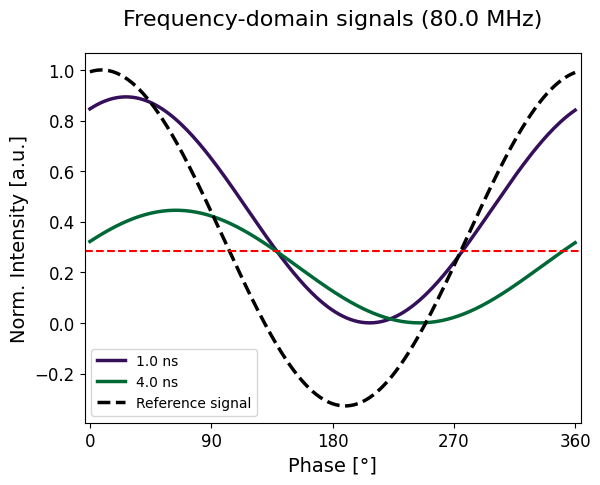

Average ≈ 0.2857


In [15]:
""" Plot normalized single-exponential frequency-domain signals by adjusting the signals to remove negative intensities,
    normalizes them, and highlights the differences between the two fluorophores and the reference signal """
purple = '#360f5a'
green = '#006837'
line = 2.5
irf_line = 2.5

# No negative intensities (Background subtraction/Correction)
ref =  -np.min(instrument_response)
signal_2_plot = signal_2 + ref - np.min(signal_2)
signal_1_plot = signal_1 + ref - np.min(signal_1)
reference_signal_plot = reference_signal


# Normalization calculations based on Modulation depth
w = (2*np.pi) / period
mod_2 = 1 / np.sqrt((1 + (w*tau_4)**2))
mod_1 = 1 / np.sqrt((1 + (w*tau_2)**2))

norm_signal_1 = signal_1_plot / np.max(signal_1_plot) * mod_2
norm_signal_2 = signal_2_plot / np.max(signal_2_plot) * mod_1
norm_reference_signal = reference_signal_plot / np.max(reference_signal_plot)
average = np.mean(reference_signal_plot)/35

#Plot figure
fig, ax = pyplot.subplots()

ax.set(
    xticks=[0, 90, 180, 270, 360],
)

ax.set_title(f'Frequency-domain signals ({frequency} MHz)', pad = 20) # Set title fontsize
ax.set_xlabel('Phase [°]')  # Set x-axis label fontsize
ax.set_ylabel('Norm. Intensity [a.u.]')  # Set y-axis label fontsize

ax.plot(phase, norm_signal_2, label= '{:.1f} ns'.format(tau_2), color = purple, linewidth = line)
ax.plot(phase, norm_signal_1, label= '{:.1f} ns'.format(tau_4), color = green, linewidth = line)
ax.plot(phase, norm_reference_signal, label='Reference signal', color = 'k', linewidth = irf_line, linestyle = '--')

ax.set_xlim(-4, 364)
plt.axhline(y=average, color='r', linestyle='--')
format_plot(ax)
ax.legend(fontsize = legendtitles)

pyplot.show()
print(f"Average \u2248 {average:.4f}")

## 5. Phasor Coordinates (Theoretical)
Before running the spatial simulation, we compute where these ideal single-exponential signals land on the phasor plot. These points represent the "ground truth" locations for $\tau_2$ and $\tau_4$.

In [16]:
# Convert the synthetic single-exponential signals into phasor coordinates
from phasorpy.phasor import phasor_from_signal
from phasorpy.lifetime import phasor_calibrate
from phasorpy.plot import PhasorPlot

# Transform the synthetic signals to the phasor space (Uncalibrated G and S)
mean, real, imag = phasor_from_signal(signal_mono)

# Transform reference signal to phasor space
reference_mean, reference_real, reference_imag = phasor_from_signal(
    reference_signal)

# Calibrate phasor coordinates using reference
# This rotates the uncalibrated phasor to the correct position on the universal circle
real, imag = phasor_calibrate(real, imag, reference_mean, reference_real, reference_imag,
                              frequency=frequency,
                              lifetime=reference_lifetime)

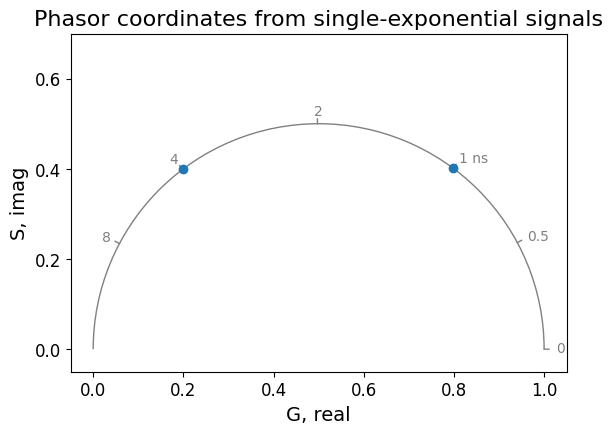

In [17]:
# Visualize the calibrated phasor coordinates of the single-exponential signals on a phasor plot
from phasorpy.plot import PhasorPlot

# Plot calibrated phasor coordinates generated from synthetic signal
plotty = True
if plotty:
  plot = PhasorPlot(frequency = frequency,
                    title='Phasor coordinates from single-exponential signals')
  plot.plot(real, imag)

  format_plot(plot.ax)

  plot.show()

## 6. Spatio-Temporal Image Simulation (3D Stack)

We now construct the full 3D data stack $I(x, y, t)$.
We place the temporal signal for $\tau_2$ at position `cx_1` and $\tau_4$ at position `cx_2`.
Initially, these are point sources (single pixels) with no blurring.

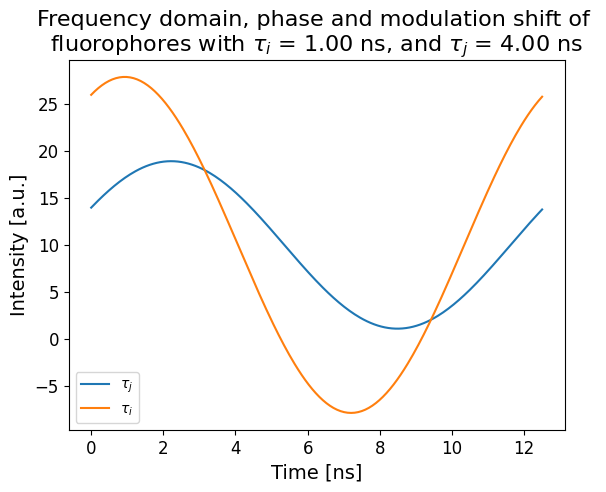

In [18]:
t_dim = settings['samples']
# Create fluorescence data stacks initialized to zero
F1xy = np.zeros((y_dim, x_dim, t_dim))
F2xy = np.zeros((y_dim, x_dim, t_dim))

# Assign the temporal signal to the specific spatial pixel (creating a point source)
F1xy[cy, cx_1, :] = signal_mono.T[:,1] # Left Fluorophore with 4ns
F2xy[cy, cx_2, :] = signal_mono.T[:,0] # Right Fluorophore with 1ns

# Create figure and axis
fig, ax = plt.subplots()

# Define the title, labels, and formatting
ax.set(
    title=f'Frequency domain, phase and modulation shift of \nfluorophores with $\\tau _i$ = {tau_2:.2f} ns, and $\\tau _j$ = {tau_4:.2f} ns',
    xlabel='Time [ns]',
    ylabel='Intensity [a.u.]',
)

# Plot fluorophore signals at their respective locations
ax.plot(times, F1xy[cy, cx_1, :], label=r'$\tau _j$')
ax.plot(times, F2xy[cy, cx_2, :], label=r'$\tau _i$')

format_plot(ax)
ax.legend(loc=3)
plt.show()

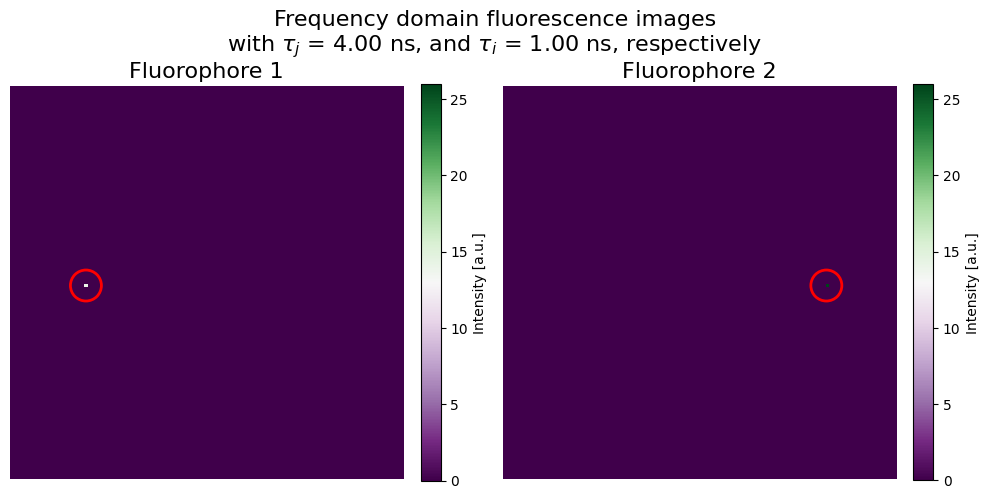

In [19]:
# Create figure and axis
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Two side-by-side subplots

#Same scale for colorbars
vmin = min(F1xy[:, :, 0].min(), F2xy[:, :, 0].min())
vmax = max(F1xy[:, :, 0].max(), F2xy[:, :, 0].max())

# Define titles using fluorophore lifetimes
title_1 = f'Fluorophore 1'
title_2 = f'Fluorophore 2'

# Plot F1xy (Frame 0) with raw intensities
im1 = axes[0].imshow(F1xy[:, :, 0], cmap=color, vmin=vmin, vmax=vmax)

# Highlight the fluorophores position
from matplotlib.patches import Circle

axes[0].add_patch(Circle((cx_1, cy), 5, fill=False, color='red', linewidth=2))
axes[0].set_title(title_1)
format_plot(axes[0])

# Plot F2xy (Frame 0) with raw intensities
im2 = axes[1].imshow(F2xy[:, :, 0], cmap=color, vmin=vmin, vmax=vmax)

axes[1].add_patch(Circle((cx_2, cy), 5, fill=False, color='red', linewidth=2))
axes[1].set_title(title_2)
format_plot(axes[1])

# Add colorbars for both images
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label="Intensity [a.u.]")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label="Intensity [a.u.]")

# Remove axis ticks for better visualization
for ax in axes:
    ax.axis("off")

# Set overall figure title using fluorophore lifetimes
fig.suptitle(f'Frequency domain fluorescence images\nwith $\\tau_j$ = {tau_4:.2f} ns, and $\\tau_i$ = {tau_2:.2f} ns, respectively', fontsize=16)

plt.tight_layout()  # Adjust layout for better spacing

plt.show()

## 7. Simulating Optical Blurring (Diffraction)
To simulate real microscopy, we convolve the point sources with a Gaussian Point Spread Function (PSF).
$$I_{convolved}(x,y,t) = I_{source}(x,y,t) * PSF(x,y)$$

This operation mixes the signals spatially. Pixels between the two fluorophores will contain a mixture of $\tau_i$ and $\tau_j$.

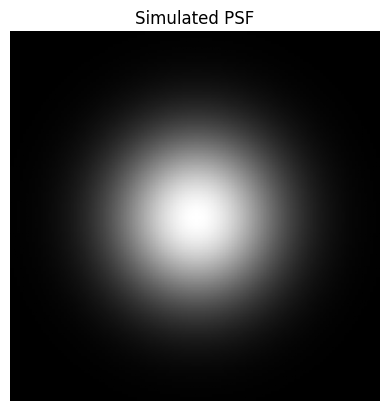

In [20]:
import scipy.signal

# Create a Gaussian-like PSF
def gaussian_psf(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf /= np.sum(psf)  # Normalize PSF so total energy is conserved
    return psf

# Define PSF size and sigma based on simulation parameters
sigma_psf = sigma_px  # Standard deviation of PSF

# Generate PSF
PSF = gaussian_psf(x_dim, sigma_psf)
plt.imshow(PSF, cmap="gray")
plt.title("Simulated PSF")
plt.axis('off')
plt.show()

# Convolve each frame in the (x, y, t) stack
# We use fftconvolve which is faster for large arrays
F1xy_convolved = np.empty_like(F1xy)
F2xy_convolved = np.empty_like(F2xy)

for t in range(t_dim):
    F1xy_convolved[:, :, t] = scipy.signal.fftconvolve(F1xy[:, :, t], PSF, mode='same')
    F2xy_convolved[:, :, t] = scipy.signal.fftconvolve(F2xy[:, :, t], PSF, mode='same')

## 8. Analyzing Blurring Effects
The plot below shows the time-domain signal at specific pixels ($p_1, p_2$). Due to convolution, the signal at a specific pixel might now contain contributions from both lifetimes.

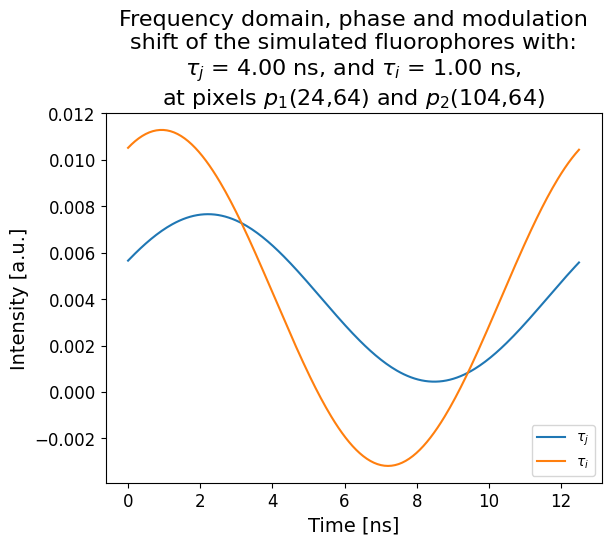

In [21]:
# Pixel labeling. The signal values as a function of position.
# Select any pixel around the center

dx_1 = 0                   # For mathematical construction to move X_1 to the right, use negative numbers
dx_2 = 0
dy_1 = 0
dy_2 = 0
X_1 = cx_1 - dx_1
X_2 = cx_2 + dx_2
Y_1 = cy + dy_1
Y_2 = cy + dy_2

fig, ax = plt.subplots()

ax.plot(times, F1xy_convolved[Y_1, X_1, :], label='$τ_j$')
ax.plot(times, F2xy_convolved[Y_2, X_2, :], label='$τ_i$')

ax.set_title(
    'Frequency domain, phase and modulation\n'
    'shift of the simulated fluorophores with:\n'
    '$τ_j$ = {:.2f} ns, and $τ_i$ = {:.2f} ns,\n'
    'at pixels $p_1$({},{}) and $p_2$({},{})'
    .format(tau_4, tau_2, X_1, Y_1, X_2, Y_2)
)

ax.set_xlabel('Time [ns]')
ax.set_ylabel('Intensity [a.u.]')

format_plot(ax)
ax.legend(loc=4)

plt.show()

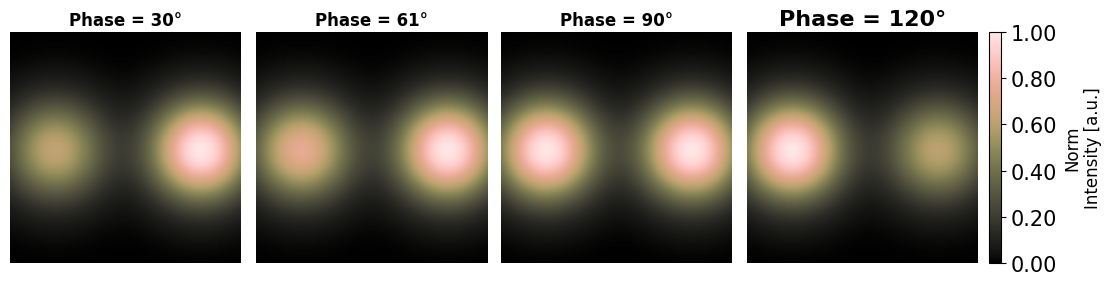

In [22]:
# Create a montage to visualize intensity changes at different phase angles
# This visualizes the "blinking" effect caused by phase differences between fluorophores

# Parameters
fr = 6  # Fixed reference frame
step = 3  # Step size
times_to_display = [1.05, 2.08, 3.11, 4.166667]  # Frames to display (time points)
phases_to_display = []

for time in times_to_display:
                    phases_to_display.append(np.round((time / period) * 360))
# Find the closest index for each value in phases_to_display
indices = [np.abs(phase - p).argmin() for p in phases_to_display]

# Import libraries
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

# Define display settings
labelsize = 15
font = 22
color = 'cmc.turku'
title = 16
weight = 'bold'

# Create figure with custom grid layout
fig = plt.figure(figsize=(13, 3))
gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 0.05, 0.02], wspace=0.05)

# Add subplots for the 4 images
axes = [fig.add_subplot(gs[0, i]) for i in range(4)]

# Plot the selected images
for ax, i in zip(axes, indices):
    montage_frame = F1xy_convolved[:, :, i] + F2xy_convolved[:, :, i]
    norm_montage_frame = montage_frame / np.max(montage_frame)
    im = ax.imshow(norm_montage_frame, cmap=color)
    ax.set_title(f"Phase = {round(phase[i])}°", pad=5, fontweight=weight)
    ax.axis("off")  # Remove axes for clean visualization

# Add colorbar in its own subplot cell
cax = fig.add_subplot(gs[0, 4])
cbar = fig.colorbar(im, cax=cax)

# Customize the colorbar
cbar.ax.yaxis.set_ticks_position('right')  # Move ticks to the right side
cbar.ax.yaxis.set_tick_params(left=False, labelleft=False)  # Remove left ticks and labels
cbar.ax.tick_params(labelsize=labelsize)
cbar.locator = ticker.MaxNLocator(nbins=5)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
cbar.set_label('Norm\nIntensity [a.u.]', fontsize=12)

format_plot(ax)

# Show final figure
plt.show()

## 9. Phasor Analysis

We process the simulated image stack as if it were experimental data.

### Step 9.1: Generate Reference Signal
Create a synthetic *reference stack* (homogeneous solution with known lifetime) to calibrate the instrument response.

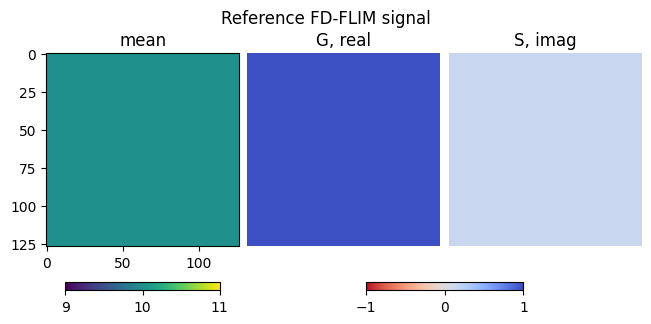

In [23]:
# Synthesize a TD-FLIM reference signal image
img_reference_signal = np.zeros((y_dim, x_dim, t_dim))

for x in range(img_reference_signal.shape[0]):  # Loop over x-dimension
    for y in range(img_reference_signal.shape[1]):  # Loop over y-dimension
        img_reference_signal[y, x, :] = reference_signal  # Assign time-domain signal

# Calculate phasor coordinates for the reference stack
img_reference_mean, img_reference_real, img_reference_imag = phasor_from_signal(
    img_reference_signal
)

from phasorpy.plot import plot_phasor_image
plot_phasor_image(
    img_reference_mean, img_reference_real, img_reference_imag, title='Reference FD-FLIM signal'
)

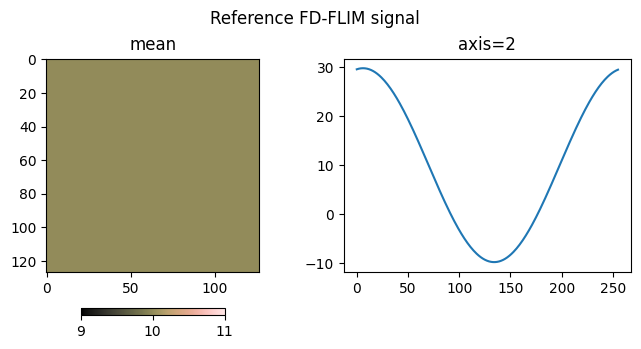

In [24]:
from phasorpy.plot import plot_signal_image

plot_signal_image(img_reference_signal, title='Reference FD-FLIM signal', cmap = color)

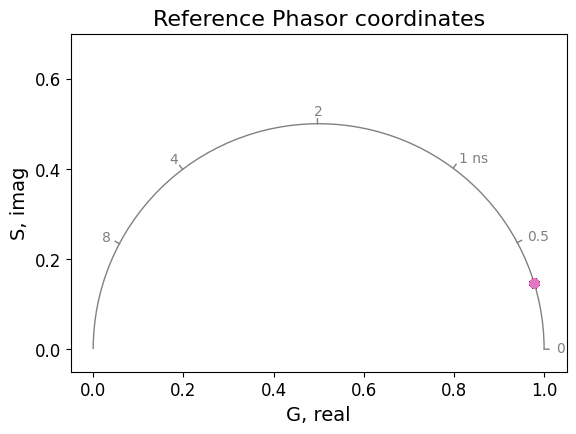

In [25]:
# Plot calibration phasor coordinates generated from synthetic signal
plotty = True
if plotty:
  plot = PhasorPlot(frequency = frequency,
                    title='Reference Phasor coordinates')
  plot.plot(img_reference_real, img_reference_imag)

  format_plot(plot.ax)

  plot.show()

### Step 9.2: Calibration and Visualization
We combine the convolved stacks, calculate their phasor coordinates, and calibrate them using the reference generated above.

The histogram below will show the distribution of lifetimes. Due to optical blurring, pixels between the two fluorophores will appear on the straight line connecting the two pure lifetimes (the "universal circle").

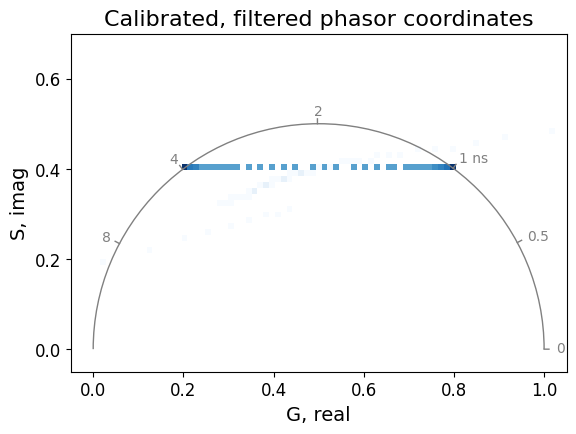

In [26]:
# Combine the convolved signals of the two fluorophores to create the full FD-FLIM image
FD_FLIM_img =F1xy_convolved + F2xy_convolved

# Compute the phasor coordinates for the FD-FLIM image
mean, real, imag = phasor_from_signal(FD_FLIM_img, axis = 2)


# Calibrate phasor coordinates using reference phasor
real, imag = phasor_calibrate(real, imag, img_reference_mean, img_reference_real, img_reference_imag,
                              frequency=frequency,
                              lifetime=reference_lifetime)

# Plot a 2D histogram of the calibrated phasor coordinates to show their distribution
phasorplot = PhasorPlot(
    frequency=frequency, title='Calibrated, filtered phasor coordinates'
)
phasorplot.hist2d(real, imag, bins = 85)
format_plot(phasorplot.ax)

plot.show()

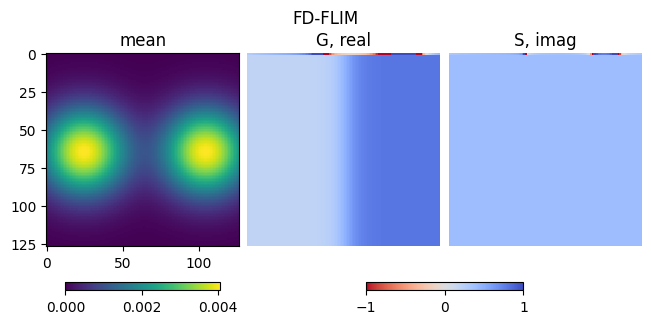

In [27]:
# Plot the image of a spatial map of the lifetime components across the simulated sample
color = 'PRGn'
from phasorpy.plot import plot_phasor_image

resolved_FLIM = plot_phasor_image(
    mean, real, imag, title='FD-FLIM'
)

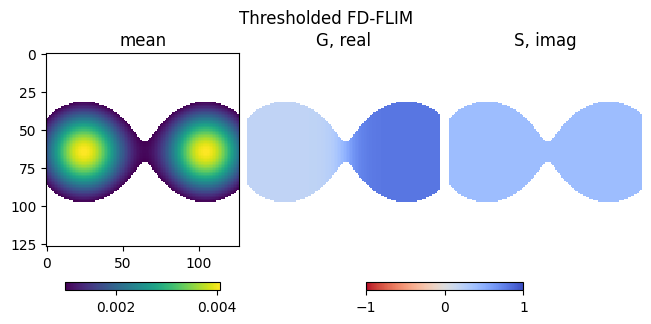

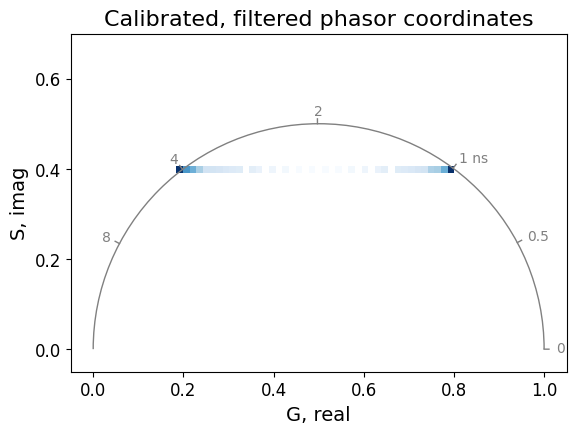

In [28]:
# Apply a threshold to the mean intensity of the FD-FLIM image to filter out low-intensity pixels
# This removes background noise which causes scatter at the origin (1,0) of the phasor plot
from phasorpy.phasor import phasor_threshold

mean_th, real_th, imag_th = phasor_threshold(mean, real, imag, mean_min=0.001)
plot_phasor_image(
    mean_th, real_th, imag_th, title='Thresholded FD-FLIM'
)
phasorplot = PhasorPlot(
    frequency=frequency, title='Calibrated, filtered phasor coordinates'
)

# Plot the thresholded phasor image and a 2D histogram of the thresholded phasor coordinates
phasorplot.hist2d(real_th, imag_th, bins = 75)
format_plot(phasorplot.ax)

plot.show()

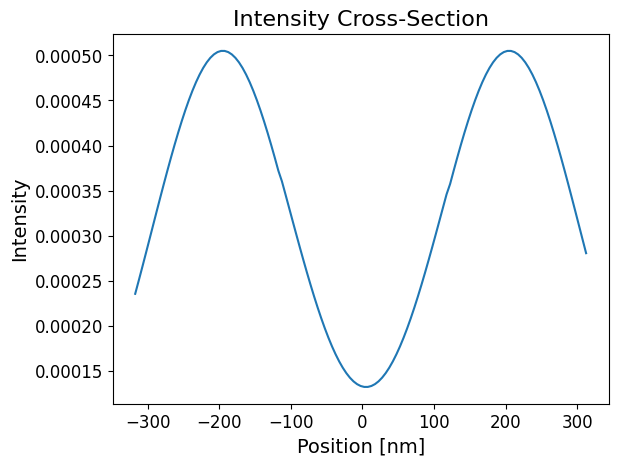

In [29]:
# Plot the cross-section of the mean intensity profile across the image.
# To visualize the spatial distribution of total fluorescence intensity after convolution, particularly focusing on the overlap region of the two fluorophores.
fig, ax = plt.subplots()

ax.plot(np.arange(-x_dim/2, x_dim/2) * pxsz, mean[cx_1, :])
ax.set_xlabel("Position [nm]")
ax.set_ylabel("Intensity")
ax.set_title("Intensity Cross-Section")

format_plot(ax)

plt.show()

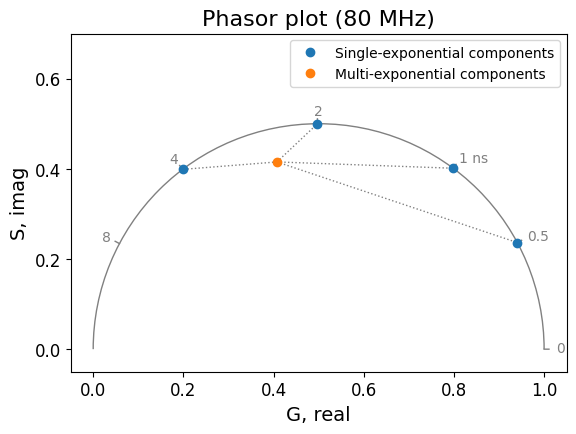

In [30]:
# Compute and visualize phasor coordinates for theoretical components
# This confirms the phasorpy library logic for multi-exponential decays
import numpy
from matplotlib import pyplot

from phasorpy.lifetime import (
    lifetime_fraction_from_amplitude,
    phasor_from_lifetime,
)
from phasorpy.plot import (
    PhasorPlot,
)


frequency = 80.0  # MHz
lifetimes = [4.0, 2.0, 1.0, 0.5]  # ns
amplitudes = [0.25, 0.25, 0.25, 0.25]  # pre-exponential amplitudes

phasor_single = phasor_from_lifetime(frequency, lifetimes)
phasor_combined = phasor_from_lifetime(
    frequency, lifetimes, amplitudes, preexponential=True
)

plot = PhasorPlot(frequency=frequency)
plot.components(
    *phasor_single, lifetime_fraction_from_amplitude(lifetimes, amplitudes)
)
plot.plot(*phasor_single, label='Single-exponential components')
plot.plot(*phasor_combined, label='Multi-exponential components')

format_plot(plot.ax)
plot.show()